In [4]:
import numpy as np
import pandas as pd
import os
import torch
from tqdm.notebook import tqdm
import seaborn as sns
import sys
from torch import nn
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
from joblib import Parallel, delayed
from rdkit import Chem
import matplotlib.patheffects as pe
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
import pickle5 as pickle
from gensim.models import word2vec
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

In [17]:
from gensim.models import word2vec

## Training the GPR

In [2]:
with open('../EnamineNewTrain.pkl', 'rb') as f:
    df_train = pickle.load(f)
with open('../EnamineNewTest.pkl', 'rb') as f:
    df_val = pickle.load(f)

In [3]:
mol_model = word2vec.Word2Vec.load('../mol2vec/examples/models/model_300dim.pkl')
mols_train = [Chem.MolFromSmiles(smile) for smile in df_train['smiles']]
mols_test = [Chem.MolFromSmiles(smile) for smile in df_val['smiles']]
sentence_train = [MolSentence(mol2alt_sentence(mol, 1)) for mol in mols_train]
sentence_test = [MolSentence(mol2alt_sentence(mol, 1)) for mol in mols_test]
embeddings_train = sentences2vec(sentence_train, mol_model, unseen='UNK')
embeddings_test = sentences2vec(sentence_test, mol_model, unseen='UNK')
X_train, y_train = embeddings_train, df_train['ba']
X_test, y_test = embeddings_test, df_val['ba']

In [4]:
X_test = np.array([np.array(X_test[i]) for i in range(0, len(X_test)) if y_test[i] < 0])
y_test = np.array([y_test[i] for i in range(0, len(y_test)) if y_test[i] < 0])
X_train = np.array([np.array(X_train[i]) for i in range(0, len(X_train)) if y_train[i] < 0])
y_train = np.array([y_train[i] for i in range(0, len(y_train)) if y_train[i] < 0])

In [5]:
idx = np.random.choice(len(X_train), 500, replace=False)
X_cur = X_train[idx]
y_cur = y_train[idx]

In [8]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.01).fit(X_cur, y_cur)
y_pred = gpr.predict(X_test)
start_mae = mean_absolute_error(y_pred, y_test)

## GPR versus Active Learning: Outside the pipeline

In [58]:
def GP_regression_std(regressor, X, n_instances=500):
    _, std = regressor.predict(X, return_std=True)
    query_idx = (-std).argsort()[:n_instances]
    return query_idx, X[query_idx]

In [7]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
kernel = RBF(5.0) 

In [60]:
learner = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.01),
    query_strategy=GP_regression_std,
    X_training=X_cur, y_training=y_cur
)

In [61]:
n_queries = 10
gpr_mae = [] 
for i in range(n_queries):
    query_idx, query_sample = learner.query(X_train)
    #print(len(X_train[query_idx]), len(y_train[query_idx].reshape(-1, 1)))
    learner.teach(X_train[query_idx], y_train[query_idx])
    y_pred = learner.predict(X_test)
    err = mean_absolute_error(y_pred, y_test)
    print(f"In iteration {i}, MAE is: {err}")
    gpr_mae.append(err)

In iteration 0, MAE is: 0.5222447795078526


/home2/karthik.viswanathan/anaconda3/envs/AltRL/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In iteration 1, MAE is: 0.5200171262481393
In iteration 2, MAE is: 0.5169567134199691


/home2/karthik.viswanathan/anaconda3/envs/AltRL/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In iteration 3, MAE is: 0.5098552350763229
In iteration 4, MAE is: 0.5101511279351767
In iteration 5, MAE is: 0.5025504617910912
In iteration 6, MAE is: 0.5037218713756737


/home2/karthik.viswanathan/anaconda3/envs/AltRL/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In iteration 7, MAE is: 0.49266395940402047


/home2/karthik.viswanathan/anaconda3/envs/AltRL/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In iteration 8, MAE is: 0.48871640203583894
In iteration 9, MAE is: 0.4896286491017333


In [121]:
n_queries = 10
random_gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.01)
random_mae = []
selected_idx = idx.copy()
random_X = X_train.copy()
random_y = y_train.copy()
random_X = np.array([random_X[i] for i in range(len(random_X)) if i not in idx])
random_y = np.array([random_y[i] for i in range(len(random_y)) if i not in idx])
for i in range(n_queries):
    idx = np.random.choice(len(random_X), 500, replace=False)
    X_cur = np.concatenate((X_cur, np.array(random_X[idx])))
    y_cur = np.concatenate((y_cur, np.array(random_y[idx])))
    random_X = np.array([random_X[i] for i in range(len(random_X)) if i not in idx])
    random_y = np.array([random_y[i] for i in range(len(random_y)) if i not in idx])
    random_gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.01).fit(X_cur, y_cur)
    y_pred = random_gpr.predict(X_test)
    err = mean_absolute_error(y_pred, y_test)
    random_mae.append(err)
    print(f"In iteration {i}, MAE is: {err}")

In iteration 0, MAE is: 0.5620478647475061
In iteration 1, MAE is: 0.5490387109325838
In iteration 2, MAE is: 0.5407496346788238


/home2/karthik.viswanathan/anaconda3/envs/AltRL/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In iteration 3, MAE is: 0.5344208221043705
In iteration 4, MAE is: 0.5308500894385132
In iteration 5, MAE is: 0.5298494370533429
In iteration 6, MAE is: 0.5256008257435546
In iteration 7, MAE is: 0.5244074742328105
In iteration 8, MAE is: 0.5217724744243672
In iteration 9, MAE is: 0.5243685004691896


In [3]:
init = 500
ts = [init]
for i in range(0, 10):
    init += 500
    ts.append(init)

In [134]:
new_random_mae = [start_mae]
new_gpr_mae = [start_mae]
new_random_mae.extend(random_mae)
new_gpr_mae.extend(gpr_mae)

In [4]:
df1 = {"ts": ts, "x": new_gpr_mae}
df2 = {"ts": ts, "x": new_random_mae}

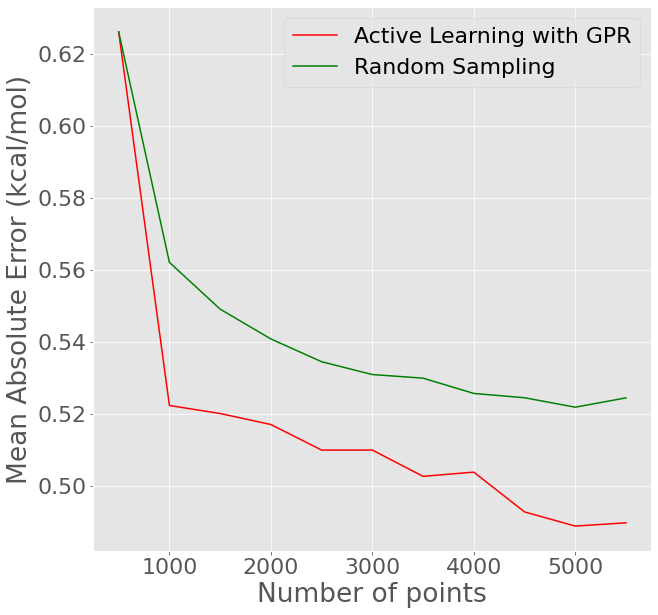

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
sns.lineplot(data=df1, x="ts", y="x", color="red", label="Active Learning with GPR")
sns.lineplot(data=df2, x="ts", y="x", color="green", label="Random Sampling")
plt.xlabel("Number of points")
plt.ylabel("Mean Absolute Error (kcal/mol)")
#plt.title("AL with GPR versus Random sampling Outside RL pipeline: MAE versus Timestep plot", fontsize=16)
plt.legend()

## Inside the pipeline: Analysing MAE, MSE and R2

- These results were obtained from the file: `results_multi_300.txt` run. The verbose has been attached in the `results/log` directory

- Two GPRs were run one on random sampling, and the other one on AL based GPR

In [10]:
mae_al = [0.41, 0.4612549500926077, 0.46323898403587427, 0.4651450029030833, 0.4686173604168406, 0.47203930715189274, 0.4745438471262515]
mae_random= [0.41, 0.5146202721367469, 0.48125186487646054, 0.4776414610704843, 0.4786466933161195, 0.4816568692425043, 0.484436715752088]
f = open('../models/results_multi_300.txt', 'r')
lines = f.readlines()
mae_vals = []
for line in lines:
    if line.startswith("MAE:") :
        mae = line.split(" ")[2]
        mae = mae[0:len(mae)-2]
        mae = float(mae)
        mae_vals.append(mae)
mae_al = [start_mae]
mae_random = [start_mae]
for i in range(0, len(mae_vals), 4):
    mae_al.append(mae_vals[i])
    mae_random.append(mae_vals[i + 1])

In [13]:
init = 5000
ts = [init]
for i in range(0, len(mae_random) - 1):
    init += 300
    ts.append(init)

In [15]:
df1 = {"ts": ts, "x": mae_al}
df2 = {"ts": ts, "x": mae_random}

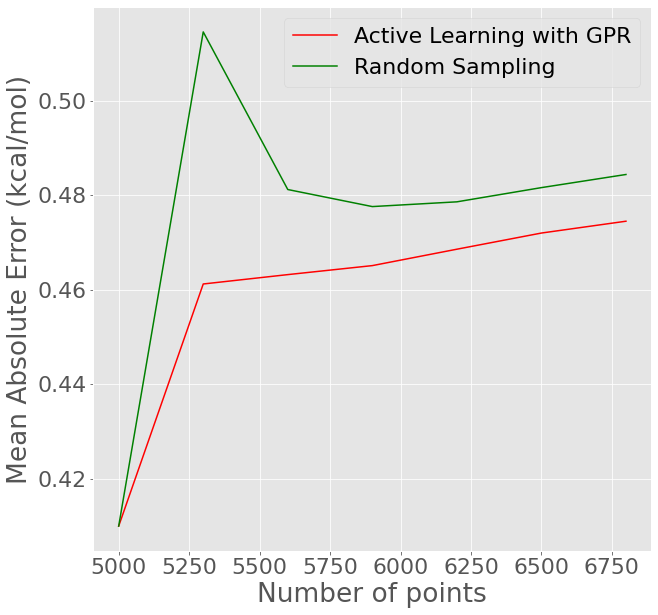

In [16]:

plt.figure(figsize=(10,10))
sns.lineplot(data=df1, x="ts", y="x", color="red", label="Active Learning with GPR")
sns.lineplot(data=df2, x="ts", y="x", color="green", label="Random Sampling")
plt.xlabel("Number of points")
plt.ylabel("Mean Absolute Error (kcal/mol)")
#plt.title("AL with GPR versus Random sampling Inside the pipeline: MAE versus Timestep plot", fontsize=16)
plt.legend()

